<!-- SOLUTION CELL -->
<h2 style="color: red">This is the solutions file!</h2>

<span style="color: red">We recommend not looking at this file, which contains the solutions to all the exercises, until after the practical is over. Use [`testing.ipynb`](testing.ipynb) instead.</span>

This is the practical component of the [Machine Learning Summer School, Moscow 2019](https://mlss2019.skoltech.ru/) session on kernels, focusing on hypothesis testing with kernel statistics.

The materials here are most recently by
[Dougal Sutherland](http://www.gatsby.ucl.ac.uk/~dougals/)
with consultation from [Arthur Gretton](http://www.gatsby.ucl.ac.uk/~gretton/),
updated from [a previous course](https://github.com/dougalsutherland/ds3-kernels/),
and based in large part on [earlier materials](https://github.com/karlnapf/ds3_kernel_testing)
by [Heiko Strathmann](http://herrstrathmann.de/).

We'll cover, in varying levels of detail, the following topics:

- Two-sample testing with the kernel Maximum Mean Discrepancy (MMD).
  - Basic concepts of hypothesis testing, including permutation tests.
  - Computing kernel values.
  - Estimators for the MMD.
  - Learning an appropriate kernel function.
- Independence testing with the Hilbert-Schmidt Independence Criterion.


## Dependencies

### Colab

If you open this notebook in Google Colab, the only thing you need to do is to intall package by using the code below. Everything will be running on cloud resources, so this is probably the easiest option if you trust that your network connection is going to be reasonably reliable. Make a copy to your own Google Drive to save your progress, and to use a GPU, click Runtime -> Change runtime type -> Hardware accelerator -> GPU. Everything you need is already installed on Colab; use a Python 3 notebook.

### Local setup

#### Python version
This notebook requires Python 3.6+. Python 3.0 was released in 2008, and it's time to stop living in the past; most importart Python projects [are dropping support for Python 2 this year](https://python3statement.org/). If you've never used Python 3 before, don't worry! It's almost the same; for the purposes of this notebook, you probably only need to know that you should write `print("hi")` since it's a function call now, and you can write `A @ B` instead of `A.dot(B)`.

#### Python packages

The main thing we use is PyTorch and Jupyter. If you already have those set up, you should be fine; just additionally make sure you also have (with `conda install` or `pip install`) `seaborn`, `tqdm`, and `sckit-learn`. We import everything right at the start, so if that runs you shouldn't hit any surprises later on.

If you don't already have a setup you're happy with, we recommend the `conda` package manager - start by installing [miniconda](https://docs.conda.io/en/latest/miniconda.html). Then you can create an environment with everything you need as:

```bash
conda create --name mlss-testing --override-channels -c pytorch -c defaults --strict-channel-priority python=3 notebook ipywidgets numpy scipy scikit-learn pytorch=1.1 torchvision matplotlib seaborn tqdm
conda activate mlss-testing

pip install --upgrade git+https://github.com/mlss-skoltech/tutorials.git

jupyter notebook
```

(If you have an old conda setup, you can use `source activate` instead of `conda activate`, but it's better to [switch to the new style of activation](https://conda.io/projects/conda/en/latest/release-notes.html#recommended-change-to-enable-conda-in-your-shell). This won't matter for this tutorial, but it's general good practice.)

(You can make your life easier when using jupyter notebooks with multiple kernels by installing `nb_conda_kernels`, but as long as you install and run `jupyter` from inside the env it will also be fine.)


## PyTorch

We're going to use PyTorch in this tutorial, even though we're not doing a ton of "deep learning." (The CPU version will be fine, though a GPU might let you get slightly better performance in some of the "advanced" sections.)

If you haven't used PyTorch before, don't worry! The API is unfortunately a little different from NumPy (and TensorFlow), but it's pretty easy to get used to; you can refer to [a cheat sheet vs NumPy](https://github.com/wkentaro/pytorch-for-numpy-users/blob/master/README.md) as well as the docs: [tensor methods](https://pytorch.org/docs/stable/tensors.html) and [the `torch` namespace](https://pytorch.org/docs/stable/torch.html#torch.eq). Feel free to ask if you have trouble figuring something out.

You can convert a `torch.Tensor` to a `numpy.ndarray` with [`t.numpy()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.numpy), and vice versa with [`torch.as_tensor()`](https://pytorch.org/docs/stable/torch.html#torch.as_tensor). (These share data when possible.) Doing this breaks PyTorch's ability to track gradients through these objects, but it's okay for things we won't need to take derivatives of. If you have a one-element tensor, you can get a regular Python number out of it with [`t.item()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.item).


$
\DeclareMathOperator{\E}{\mathbb E}
\DeclareMathOperator{\Var}{Var}
\DeclareMathOperator{\Tr}{Tr}
\DeclareMathOperator{\MMD}{MMD}
\DeclareMathOperator{\MMDhat}{\widehat{MMD}}
\newcommand{\PP}{\mathbb{P}}
\newcommand{\QQ}{\mathbb{Q}}
\newcommand{\h}{\mathcal H}
$

In [1]:
!pip install --upgrade git+https://github.com/mlss-skoltech/tutorials.git#subdirectory=kernels

  Cloning https://github.com/mlss-skoltech/tutorials.git to /tmp/pip-req-build-4yk66ni1
  Running command git clone -q https://github.com/mlss-skoltech/tutorials.git /tmp/pip-req-build-4yk66ni1
  Created wheel for probability-testing: filename=probability_testing-0.1-cp36-none-any.whl size=44701143 sha256=d0bdc1d6b4f151e641526439abbe9cdf0ab915d325de154e8ac804fa3cefbd61
  Stored in directory: /tmp/pip-ephem-wheel-cache-hvaxd_06/wheels/1c/ff/0c/f3305230108851e03edfa4079089ad89d7bec493e4c4d0d070
Successfully built probability-testing


In [0]:
import os
import pkg_resources

DATA_PATH = pkg_resources.resource_filename('probability_testing', 'data/')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook')
from IPython.display import display, Markdown, HTML

from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm  # if you're in JupyterLab/etc and tqdm_notebook doesn't work well

import functools

import numpy as np
import sklearn
from sklearn import model_selection
import torch

from probability_testing.support import as_tensors, maybe_squeeze

## A note

Please ask for help if you get stuck! Whether it's with a code thing or something conceptual, your instructors are happy to help you try to work through things. Solutions are also available in [`solutions-testing.ipynb`](solutions-testing.ipynb), but you're probably better off not rushing straight to those.

## Starting out with two-sample testing

In [0]:
# SOLUTION CELL
# Generate the data...mean-shifted Gaussians
N = 1000
rs = np.random.RandomState(seed=0)
X = rs.randn(N, 1).astype(np.float32)
Y = rs.randn(N, 1).astype(np.float32) + 0.2
np.savez(os.path.join(DATA_PATH, 'simple.npz'), X=X, Y=Y)

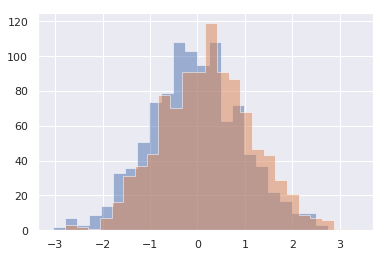

In [4]:
with np.load(os.path.join(DATA_PATH, 'simple.npz')) as data:
    X, Y = as_tensors(data['X'], data['Y'])
    
plt.hist(X.numpy(), alpha=.5, bins='auto', histtype='stepfilled')
plt.hist(Y.numpy(), alpha=.5, bins='auto', histtype='stepfilled');

Question: do $X$ and $Y$ come from the same distribution?

## Comparing means

Let's start by comparing the means of the samples.
If the distributions are the same, their means are the same,
so the expectation of this statistic would be zero.

In [5]:
def mean_difference(X, Y, squared=False):
    # make sure X and Y are 1d tensors:
    # the data files have them as [n, 1] to go with Python convention
    # (and for us to use later)
    X, Y = [maybe_squeeze(t, 1) for t in as_tensors(X, Y)]
    assert len(X.shape) == len(Y.shape) == 1
    
    # TODO: compute mean difference of X and Y in `result`
    result = X.mean() - Y.mean()  # SOLUTION
    
    return (result * result) if squared else result

mean_difference(X, Y).item()

-0.2588736414909363

Well, it's not zero...but of course we were never going to get *exactly* zero.

Where do we draw the line?

The classical statistical way to do this is to assume that $P_X = P_Y$ (the null hypothesis), and consider what the distribution of the test statistic would be in that case (the null distribution). If the number we observe would be very unlikely under the null distribution, then we "reject the null" and say that the two samples are different.

One way to do this is called _permutation testing_.

### Permutation testing (distribution of test statistic under $P_X = P_Y$)

This is based on the observation that if $P_X = P_Y$, then we can shuffle the samples together, and that won't change the distribution of our shuffled $X'$ or $Y'$ (under the null hypothesis). We can then compute what our test statistic would be if we did this a bunch of times, and this will give us an estimate of what the true null distribution is. If we do a lot of permutation samples, and our test statistic landed above, say, 99% of them, then we can reject the null hypothesis.

Permutation test procedure
1. Concatenate `X` and `Y` into a new set `Z`
2. Shuffle samples in `Z`
3. Split `Z` into two sets `X'` and `Y'` of sizes $n_X$ and $n_Y$
4. Calculate test statistics using `X'` and `Y'`
5. Repeat steps 1-4 several times

**Exercise:** fill in the following method for implementing two-sample tests. Here `test_statistic` is a variable representing a function, like `mean_difference`, that will compute some statistic given two inputs.

In [0]:
def two_sample_permutation_test(
    test_statistic, X, Y, num_permutations=500, progress=True
):
    X, Y = as_tensors(X, Y)
    assert X.shape[1:] == Y.shape[1:]  # check same dimensionality
    
    orig_stat = test_statistic(X, Y)
    
    range_ = range(num_permutations)
    if progress:
        range_ = tqdm(range_)
    
    # concatenate samples together                    # SOLUTION
    Z = torch.cat([X, Y], 0)                          # SOLUTION
    n_X = X.shape[0]                                  # SOLUTION
    
    stats = []
    for i in range_:
        # TODO: compute test statistic on permuted samples, in `this_stat`
        np.random.shuffle(Z.numpy())                  # SOLUTION
        this_stat = test_statistic(Z[:n_X], Z[n_X:])  # SOLUTION
        stats.append(this_stat)
    
    return orig_stat, torch.stack(stats)

Here's a helper function I'll give you to visualize the results of the permutation:

In [0]:
def plot_null_samples(
    statistic,        # the value of the actual test statistic
    null_samples,     # an array of samples from the statistic's null distribution
    ax=None,          # a matplotlib axis object; none for the default one
    from_zero=False,  # indicate it's a one-sided test whose statistic is always >= 0
    one_sided=True,   # indicate it's a one-sided test for high values of the statistic
    alpha=1,          # transparency of the histogram for the null samples
    level=0.05,       # level of the test, e.g. 0.05 for 5% false rejection rate
):
    null_samples = np.asarray(null_samples)
    if ax is None:
        ax = plt.gca()

    ax.hist(
        null_samples,
        bins="auto",
        histtype="stepfilled",
        label="Permutation samples",
        alpha=alpha,
        density=True,
    )

    if from_zero:
        lo = 0
        hi = np.percentile(null_samples, 100 * (1 - level))
    elif one_sided:
        lo = np.min(null_samples) - 0.02 * (np.max(null_samples) - np.min(null_samples))
        # should be -inf, but axvspan doesn't support that
        hi = np.percentile(null_samples, 100 * (1 - level))
    else:
        lo = np.percentile(null_samples, 100 * level / 2)
        hi = np.percentile(null_samples, 100 * (1 - level / 2))

    ax.axvspan(lo, hi, fc="b", alpha=0.25, label=f"{1 - level:.1%} region")

    ax.axvline(x=statistic, c="r", lw=2, label="Actual statistic")
    ax.legend(loc="best")

    ax.set_xlabel("Test statistic value")
    ax.set_ylabel("Density")

    if from_zero:
        ax.set_xlim(0, ax.get_xlim()[1])
    elif one_sided:
        ax.set_xlim(lo, ax.get_xlim()[1])

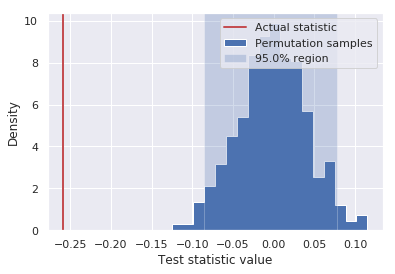

In [8]:
plot_null_samples(
    *two_sample_permutation_test(mean_difference, X, Y),
    one_sided=False)

# The * here is a bit of Python helper syntax. If you haven't seen it before,
# fn(*it) calls fn like fn(it[0], it[1], ...) for the length of it,
# so here it's like doing
#   stat, nulls = two_sample_permutation_test(...)
#   plot_null_samples(stat, nulls)

Depending on the test statistic, there might be many other ways to compute the null distribution.
Not all of them work via sampling it directly like this – which can be pretty expensive, e.g. 500 times as expensive as the test in the first place....

For example, for our mean difference test statistic, if we assume that $X$ and $Y$ are each Gaussian, the distribution of the statistic is also Gaussian – as we can see, at least roughly, in this plot. 
We might be even able to analytically work out the parameters of this distribution.

If you haven't realized, this would be basically a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), where we assume that we know that both distributions have the same variance so we can distinguish them via solely looking at their mean. (In this particular case, that's true....)

The advantage of permutation tests, though, is that you don't have to make strong parametric assumptions like this.

As it will be useful for kernel based test statistics later, we will also look at the distribution of a squared test statistic, in order to make it strictly positive, but still tend to zero if the two distributions are the same.

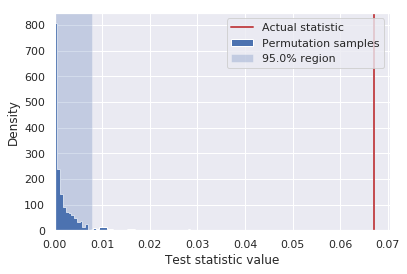

In [9]:
squared_mean_diff = functools.partial(mean_difference, squared=True)
# squared_mean_diff is a new function object that just calls mean_difference,
# but defaults the `squared` argument to True

plot_null_samples(
    *two_sample_permutation_test(squared_mean_diff, X, Y),
    from_zero=True)

### Alternative distribution via explicit simulation (distribution of test statistic under $P_X \neq P_Y$)

The test statistic also has a distribution under the alternative hypothesis ($P_X \neq P_Y$); our computed test statistic is only a single sample from this distribution.

Unfortunately, it's not easy to look at this alternative distribution in practice,
unless we have a way to generate more data.
But let's take a look in a synthetic case where we know the true distribution.

**Exercise:** sample from the alternative to make the comparison plot below.

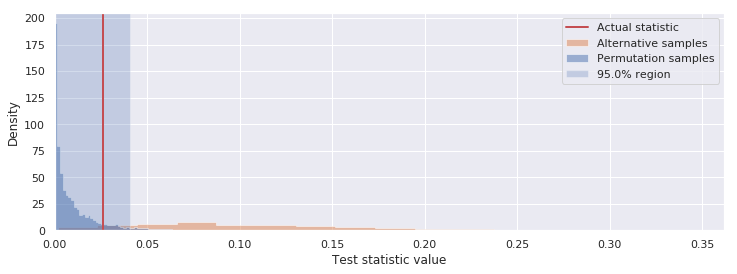

In [10]:
np.random.seed(0); torch.manual_seed(5)

# This is a case when the null hypothesis is false:
N = 200
sample_X = lambda: torch.randn(N, 1)
sample_Y = lambda: torch.randn(N, 1) + 0.3

# Do the normal testing thing, where we have one sample from each.
X = sample_X()
Y = sample_Y()

# single sample from the alternative + null estimates
stat, perm_samples = two_sample_permutation_test(squared_mean_diff, X, Y, num_permutations=5000)

statistics_alt = np.zeros(500)
# TODO: fill statistics_alt with samples from the alternative distribution
for i in tqdm(range(statistics_alt.shape[0])):                     # SOLUTION
    statistics_alt[i] = squared_mean_diff(sample_X(), sample_Y())  # SOLUTION


fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(statistics_alt, alpha=0.5, bins='auto', density=True,
        label='Alternative samples', histtype='stepfilled',
        color=sns.color_palette()[1])
plot_null_samples(stat, perm_samples, ax=ax, from_zero=True, alpha=.5)

As you can see, even though most of the alternative distribution is far larger than the null, we can be unlucky: there are a significant portion of datasets for which the test would not reject the null simply by chance.
This particular seed was one of the unlucky ones: most of the time we'd reject, but this time we didn't. The probability with which the test rejects when the alternative is false is called the *power*.

**Optional:** Play with the sample size, or the amount of difference between $X$ and $Y$, and see how this impacts the position of the alternative distribution (and as such the test power).

**Optional:** Actually generate more data from the null distribution, also. How well does the permutation distribution approximate the true null? How does this change with smaller / larger `N`?

### Another dataset

In [0]:
# SOLUTION CELL
# gaussian vs laplace with same mean / variance
from scipy import stats

np.random.seed(2)
N = 300
X = stats.norm.rvs(size=(N, 1)).astype(np.float32)
Y = stats.laplace.rvs(size=(N, 1), scale=np.sqrt(.5)).astype(np.float32)

np.savez(os.path.join(DATA_PATH, 'almost_simple.npz'), X=X, Y=Y)

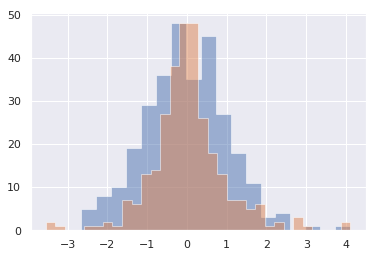

In [12]:
with np.load(os.path.join(DATA_PATH, 'almost_simple.npz')) as d:
    X, Y = as_tensors(d['X'], d['Y'])

plt.hist(X.numpy(), alpha=.5, bins='auto', histtype='stepfilled')
plt.hist(Y.numpy(), alpha=.5, bins='auto', histtype='stepfilled');

Looks like the mean won't cut it this time. Maybe the standard deviation?

**Exercise:** Implement a two-sample test statistic based on both the mean and the standard deviation, e.g. $(\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2$.

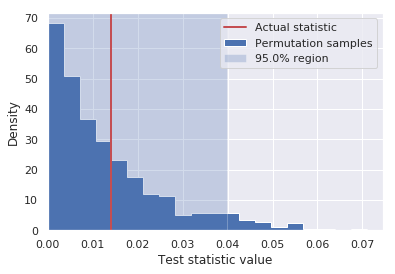

In [13]:
def mean_std_stat(X, Y):
    # make data 1d
    X, Y = [maybe_squeeze(t, 1) for t in as_tensors(X, Y)]
    assert len(X.shape) == len(Y.shape) == 1
    
    # TODO: return some statistic based on the mean and std dev
    return (X.mean() - Y.mean()) ** 2 + (X.std() - Y.std()) ** 2    # SOLUTION

plot_null_samples(
    *two_sample_permutation_test(mean_std_stat, X, Y),
    from_zero=True)  # if your statistic can be negative, remove the from_zero argument...

At least for the statistic I picked, this was comfortably inside the rejection region, even though visually the samples are quite different.

Of course, it's possible we were just unlucky (as we saw could happen above) – but actually, the distributions I generated this data from have exactly the same means and standard deviations. Clearly, this test is never going to be able to tell such data apart, so it's time to move onto something better. We could keep adding more and more moments, but those get hard to estimate pretty quickly, so let's remember what we talked about in the lectures instead.

## Maximum Mean Discrepancy

As we saw in the lectures, the MMD can be thought of as either
$$
\MMD(\PP, \QQ)
= \sup_{f \in \h : \lVert f \rVert_\h \le 1} \E_{X \sim \PP}[f(X)] - \E_{Y \sim \QQ}[ f(Y) ]
$$
or, more relevantly right now,
$$
\MMD(\PP, \QQ)
=
\lVert
\E_X[ \varphi(X) ]
- \E_Y[ \varphi(Y) ]
\rVert_\h
$$
where $\varphi : \mathcal X \to \h$ is the feature map of the kernel $k(x, y) = \langle \varphi(x), \varphi(y) \rangle_\h$.

If we take $\varphi(x) = x$, corresponding to a linear kernel, then our squared difference in means is exactly the squared MMD. But we can do a lot better by picking a different kernel.

**Exercise:** does the difference in means + standard deviations you used above correspond to an MMD with some kernel? If so, what kernel? If not, is there a kernel MMD that can distinguish the same set of distributions as that can?

## Computing kernels

To help organize computing kernels, I've put some infrastructure in the `LazyKernel` class (in `probaiblity_testing.support.kernels`, if you want to look at it). It handles a bunch of gruntwork that you won't want to deal with later on. Here's an example of how to use it to implement a kernel:

In [0]:
from probability_testing.support import LazyKernel

class LinearKernel(LazyKernel):
    def _compute(self, X, Y):
        return X @ Y.t()

Here, the `_compute` method computes the kernel between two matrices of inputs, `X` and `Y`, of shape `[n_X, dim]` and `[n_Y, dim]`; it returns a kernel matrix of shape `[n_X, n_Y]`. (Here, `.t()` is PyTorch syntax for a transpose, and `@` is the nifty Python 3.6+ syntax for matrix multiplication.)

The `LazyKernel` base class lets us use this in various ways. First, to find the kernel from one set of points to another:

In [0]:
K = LinearKernel(X, Y)

To get the kernel matrices X-to-Y, X-to-X or Y-to-Y you can use `K.XY`, `K.XX` and `K.YY` repsectively  
*(which are the result of `_compute(X, X)` and `_compute(Y, Y)`. These aren't computed until you need them, but then they're cached after you use them the first time; this is why it's a `LazyKernel`.)*

In [16]:
K.XX, K.XY, K.YY

(tensor([[1.7369e-01, 2.3450e-02, 8.9028e-01,  ..., 2.0335e-01, 7.2129e-02,
          1.6476e-01],
         [2.3450e-02, 3.1660e-03, 1.2020e-01,  ..., 2.7454e-02, 9.7382e-03,
          2.2245e-02],
         [8.9028e-01, 1.2020e-01, 4.5633e+00,  ..., 1.0423e+00, 3.6971e-01,
          8.4454e-01],
         ...,
         [2.0335e-01, 2.7454e-02, 1.0423e+00,  ..., 2.3808e-01, 8.4447e-02,
          1.9290e-01],
         [7.2129e-02, 9.7382e-03, 3.6971e-01,  ..., 8.4447e-02, 2.9954e-02,
          6.8423e-02],
         [1.6476e-01, 2.2245e-02, 8.4454e-01,  ..., 1.9290e-01, 6.8423e-02,
          1.5630e-01]]),
 tensor([[-1.6379e-01, -2.9012e-01,  1.2551e-01,  ...,  1.2863e-02,
          -3.0638e-01, -4.1088e-01],
         [-2.2113e-02, -3.9169e-02,  1.6945e-02,  ...,  1.7367e-03,
          -4.1365e-02, -5.5473e-02],
         [-8.3954e-01, -1.4871e+00,  6.4334e-01,  ...,  6.5933e-02,
          -1.5704e+00, -2.1061e+00],
         ...,
         [-1.9176e-01, -3.3966e-01,  1.4695e-01,  ...,  1.506

If you only want the kernel matrix for a dataset to itself, you can just not pass the second argument. Then `K.XY` won't exist.

In [17]:
LinearKernel(X)

<LinearKernel(300)>

You can also pass three arguments; then there'll be `XZ`, etc. You can also access them with e.g. `K[0, 2]`.

Alternatively, you can pass `None`, which is a special value meaning "use the first one." Then `XY` and so on will exist, but it knows to cache them appropriately.

In [18]:
K = LinearKernel(X, None, Y)
print(K)
K.YZ

<LinearKernel(300, 300, 300)>


tensor([[-1.6379e-01, -2.9012e-01,  1.2551e-01,  ...,  1.2863e-02,
         -3.0638e-01, -4.1088e-01],
        [-2.2113e-02, -3.9169e-02,  1.6945e-02,  ...,  1.7367e-03,
         -4.1365e-02, -5.5473e-02],
        [-8.3954e-01, -1.4871e+00,  6.4334e-01,  ...,  6.5933e-02,
         -1.5704e+00, -2.1061e+00],
        ...,
        [-1.9176e-01, -3.3966e-01,  1.4695e-01,  ...,  1.5060e-02,
         -3.5871e-01, -4.8105e-01],
        [-6.8018e-02, -1.2048e-01,  5.2122e-02,  ...,  5.3418e-03,
         -1.2723e-01, -1.7063e-01],
        [-1.5537e-01, -2.7521e-01,  1.1906e-01,  ...,  1.2202e-02,
         -2.9064e-01, -3.8977e-01]])

There are also some useful methods in `LazyKernel` that you can find in the source code for it.

**Exercise:** Remember from lecture that a *characteristic* kernel can distinguish *any* pair of distributions (with enough samples). None of the kernels we've implemented so far are characteristic. Your job is to implement one: the kernel that goes by names including exponentiated quadratic, squared exponential, Gaussian RBF, and probably more:

$$k(X_i, X_j) = \exp\left( -\frac{1}{2 \sigma^2} \lVert X_i - X_j \rVert^2 \right).$$

It might be helpful to recall that
$$\lVert X_i - X_j \rVert^2 = \lVert X_i \rVert^2 + \lVert X_j \rVert^2 - 2 X_i^T X_j;$$
you should probably convert that into a matrix form to implement it in `_compute`.

Alternatively, [`torch.pdist`](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.pdist) computes these distances, but it only gives you the upper triangle of the matrix so you'll have to turn it into a full symmetric matrix yourself.

In [0]:
class ExpQuadKernel(LazyKernel):
    def __init__(self, *parts, sigma=1):
        super().__init__(*parts)
        self.sigma = sigma
        self.const_diagonal = 1  # Says that k(x, x) = 1 for any x.
                                 # Just a slight optimization; not really necessary.
    
    # TODO: implement _compute
    def _compute(self, A, B):                                            # SOLUTION
        A_sqnorms = torch.einsum("ij,ij->i", A, A)
        B_sqnorms = torch.einsum("ij,ij->i", B, B)
        D2 = A_sqnorms[:, None] + B_sqnorms[None, :] - 2 * (A @ B.t())   # SOLUTION
        return torch.exp(D2 / (-2 * self.sigma ** 2))                    # SOLUTION

You can check your implementation against scikit-learn's implementation (but it doesn't work in PyTorch, so don't just use it directly):

In [0]:
sigma = np.random.lognormal()
K = ExpQuadKernel(X, Y, sigma=sigma)

from sklearn.metrics.pairwise import rbf_kernel
gamma = 1 / (2 * sigma**2)  # sklearn uses this parameterization
assert np.allclose(K.XX.numpy(), rbf_kernel(X, gamma=gamma))
assert np.allclose(K.XY.numpy(), rbf_kernel(X, Y, gamma=gamma))
assert np.allclose(K.YY.numpy(), rbf_kernel(Y, gamma=gamma))
del rbf_kernel

### `Matrix` classes

Okay, one more handy thing about these `LazyKernel` classes that might be useful here. (You don't have to use them, but you can.)

if you do `K.XY_m` (or `K.YY_m` or `K.matrix(0, 1)`, etc), then you get a special `support.kernels.Matrix` subclass. This implements – and caches – various operations you might need. Let's take a look:

In [0]:
K = ExpQuadKernel(X, Y)

In [22]:
K.XY_m, K.XX_m

(<SquareMatrix, 300 by 300>, <SymmetricConstDiagMatrix, 300 by 300>)

There are several offdiagonal operations that you may need later:

In [23]:
print('  \n'.join(m for m in dir(K.XY_m) if not m.startswith('_') and 'offdiag' in m))

offdiag_col_sums  
offdiag_col_sums_sq_sum  
offdiag_mean  
offdiag_row_sums  
offdiag_row_sums_sq_sum  
offdiag_sq_sum  
offdiag_sum


In [24]:
K.XX_m.mean(), K.XX_m.offdiag_mean()

(tensor(0.5669), tensor(0.5655))

Check out the second half of `probability_testing.support.kernels` to see how they're implemented / what options there are.

### MMD estimators

Okay, enough admiring my beautiful code. Remember that we have
\begin{align}
\MMD^2(\PP, \QQ)
  &= \lVert \E_X[ \varphi(X) ] - \E_Y[ \varphi(Y) ] \rVert_\h^2
\\&= \langle
        \E_X[ \varphi(X) ] - \E_Y[ \varphi(Y) ],
        \E_X[ \varphi(X) ] - \E_Y[ \varphi(Y) ]
     \rangle_\h
\\&= \langle \E_X[ \varphi(X) ], \E_X[ \varphi(X) \rangle_\h
   + \langle \E_Y[ \varphi(Y) ], \E_Y[ \varphi(Y) \rangle_\h
   - 2 \langle \E_X[ \varphi(X) ], \E_Y[ \varphi(Y) ] \rangle_\h
\\&= \E_{X, X', Y, Y'}\left[
     \langle \varphi(X), \varphi(X') \rangle_\h
   + \langle \varphi(Y), \varphi(Y') \rangle_\h
   - 2 \langle \varphi(X), \varphi(Y) \rangle_\h
   \right]
\\&= \E_{X, X', Y, Y'}\left[
     k(X, X')
   + k(Y, Y')
   - 2 k(X, Y)
   \right]
.\end{align}

This gives a pretty natural idea for how to estimate the MMD. Well, three ideas of varying amounts of naturalness:

The *biased* estimator (exactly the MMD between the empirical distributions) is, if we have $m$ samples from $X$ and $n$ from $Y$:
$$
\MMDhat_b^2(X, Y)
= \frac{1}{m^2} \sum_{i=1}^m \sum_{j=1}^m k(X_i, X_j)
+ \frac{1}{n^2} \sum_{i=1}^n \sum_{j=1}^n k(Y_i, Y_j)
- \frac{2}{m n} \sum_{i=1}^m \sum_{j=1}^n k(X_i, Y_j)
.$$
But this term has a bias due to the $k(X_i, X_i)$ and $k(Y_i, Y_i)$ terms.

(You can tell that it's biased because if $X$ and $Y$ are each samples from the same distribution, the true MMD value is $0$, usually $\MMDhat^2(X, Y) > 0$, and it's not possible to have $\MMDhat^2(X, Y) < 0$ – thus $\E \MMDhat^2(X, Y) > 0$.)

The *unbiased* estimator gets rid of these terms:
$$
\MMDhat_u^2(X, Y)
= \frac{1}{m (m-1)} \sum_{i \ne j}^m k(X_i, X_j)
+ \frac{1}{n (n-1)} \sum_{i \ne j}^n k(Y_i, Y_j)
- \frac{2}{m n} \sum_{i=1}^m \sum_{j=1}^n k(X_i, Y_j)
.$$
This makes it unbiased; in fact, it's the minimum variance unbiased estimator.

The $U$-statistic estimator only works when $n = m$, and also takes out the $k(X_i, Y_i)$ terms, which gives you a slightly worse estimator:
$$
\MMDhat_U^2(X, Y)
= \frac{1}{m (m-1)} \sum_{i \ne j}^m \left(
    k(X_i, X_j) + k(Y_i, Y_j) - 2 k(X_i, Y_j)
  \right)
.$$
The advantage is that $U$-statistics have been studied pretty thoroughly by statisticians, so we know things about their variance and asymptotic distributions and whatnot.

**Exercise:** Implement at least one of these estimators, as functions of a `LazyKernel(X, Y)`. Using the `Matrix` helpers, each can be literally one line, but you can implement it however you feel like. You don't necessarily have to do all three; do at least one of them, but the others aren't too much extra work on top of the first one.

In [0]:
def mmd2_biased(K):
    pass  # TODO: implement, using K.XX_m, K.XY_m, K.YY_m (or K.XX, K.XY, K.YY)
    return K.XX_m.mean() + K.YY_m.mean() - 2 * K.XY_m.mean()  # SOLUTION

def mmd2_unbiased(K):
    pass  # TODO: implement
    return K.XX_m.offdiag_mean() + K.YY_m.offdiag_mean() - 2 * K.XY_m.mean()  # SOLUTION

def mmd2_u_stat(K):
    assert K.ns[0] == K.ns[1]
    # TODO: implement
    return K.XX_m.offdiag_mean() + K.YY_m.offdiag_mean() - 2 * K.XY_m.offdiag_mean()  # SOLUTION

Check your implementation

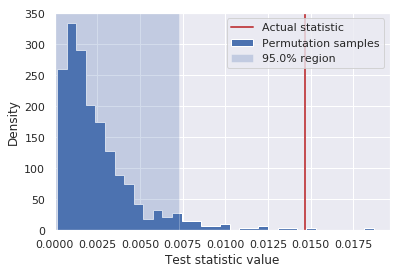

In [26]:
plot_null_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_biased(ExpQuadKernel(X, Y)), X, Y),
    from_zero=True)

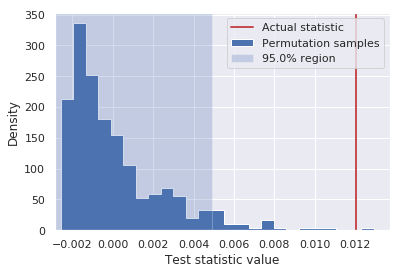

In [27]:
plot_null_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_unbiased(ExpQuadKernel(X, Y)), X, Y))

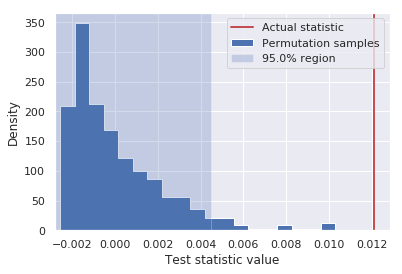

In [28]:
plot_null_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_u_stat(ExpQuadKernel(X, Y)), X, Y))

They're all pretty much the same; when you're just doing permutation testing, the differences between them aren't super important.

**Exercise:** Run the test with a `LinearKernel`. Which of our estimators, if any, corresponds to the `mean_difference` statistic from before? (Do you understand why?)

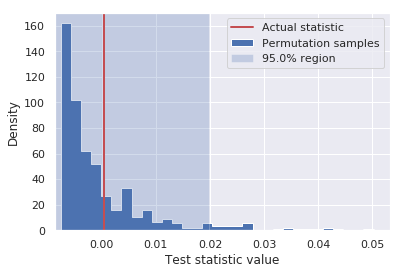

In [29]:
# SOLUTION CELL
plot_null_samples(
    *two_sample_permutation_test(lambda X, Y: mmd2_u_stat(LinearKernel(X, Y)), X, Y))

In [30]:
# SOLUTION CELL
# Answer: it's mmd2_biased, as you can see e.g. by
# expanding k(x, y) = x y in the equation for the sum.
# Here's the numerical check:
K = LinearKernel(X, Y)
torch.stack([
    mean_difference(X.squeeze(1), Y.squeeze(1), squared=True),
    mmd2_biased(K),
    mmd2_unbiased(K),
    mmd2_u_stat(K),
])

tensor([6.7584e-03, 6.7584e-03, 3.7809e-06, 4.6972e-04])

**Optional:** We're working on small datasets here so far, so this implementation of permutations is fine. But notice that we're recomputing the kernel matrix for each permutation, even though the matrices actually have all the same elements (just in jumbled-up order). Implement a faster way that doesn't involve this recomputation.

Hint: this is easiest for the biased estimator, which you can write in a way amenable to [this kind of approach](https://pytorch.org/docs/stable/torch.html#torch.einsum). (The `LazyKernel.joint()` method, which concatenates all the kernel matrices together, might be useful.) Doing some algebra to work out a few slightly annoying correction terms, you can also do it similarly for the U-statistic estimator.

If you're really, really careful, you can also make the unbiased estimator really fast (exploiting cache locality and things like that). We wrote about this in [this paper](https://arxiv.org/abs/1611.04488) (Section 3), and it's implemented in [Shogun](https://www.shogun-toolbox.org/). (Example usage [here](http://shogun.ml/examples/latest/examples/statistical_testing/quadratic_time_mmd.html) or in in [this notebook](https://nbviewer.jupyter.org/github/shogun-toolbox/shogun/blob/develop/doc/ipython-notebooks/statistical_testing/mmd_two_sample_testing.ipynb).)

_Extra credit:_ empirically compare how our silly implementation here, your faster implementation, and the Shogun implementation scale as the dataset size increases.

In [0]:
# Override this function if you implement a better one yourself,
# and the stuff later will run faster....
# This just establishes an API for passing in a kernel directly,
# which is a little clumsy to implement, but it's not any faster.
def mmd2_permutations_slow(K, use_biased=False, num_permutations=1000, progress=True):
    # Some fiddling to be able to use the same kernel with "new" data.
    assert K.n_parts == 2
    from copy import copy
    K_copy = copy(K)
    def mmd2_with_K(X, Y):
        K_copy.change_part(0, X)
        K_copy.change_part(1, Y)
        return (mmd2_biased if use_biased else mmd2_unbiased)(K_copy)
    
    return two_sample_permutation_test(
        mmd2_with_K, K.X, K.Y,
        num_permutations=num_permutations, progress=progress)

mmd2_permutations = mmd2_permutations_slow

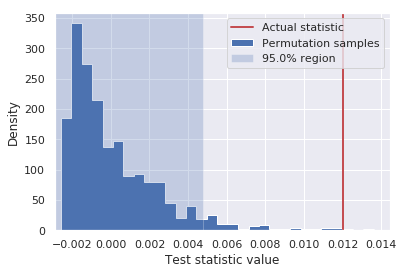

In [32]:
K = ExpQuadKernel(X, Y, sigma=1)
plot_null_samples(*mmd2_permutations_slow(K))

**Answer**: the MMD computation can be expressed as follows:
$$
MMD = \mathbf{w}^{\top} \begin{pmatrix}
  K_{XX} & K_{XY} \\
  K_{YX} & K_{YY}
\end{pmatrix}
\mathbf{w}, \quad \mathbf{w} = \begin{pmatrix} \frac{1}{n} \mathbf{1}_n \\ -\frac{1}{m} \mathbf{1} \end{pmatrix}
$$
The permutations then corresponds to permutations in $\mathbf{w}$

In [0]:
# SOLUTION CELL

# For the biased estimator, note that
#   MMD_b^2(X, Y) = \sum_{i,j} w_i Kjoint_{ij} w_j
#   with w_i = 1/n_X if i is in X, -1/n_Y if it's in Y.
# Then we just do that simultaneously for a bunch of ws.
def mmd2_biased_permutations(K, num_permutations=1000, progress=None):
    # progress argument is ignored
    full_kernel = K.joint()
    assert K.n_parts == 2
    n_X, n_Y = K.ns
    n_tot = n_X + n_Y

    # assign permutations; last row is the true split
    ws = full_kernel.new_full((num_permutations + 1, n_tot), -1 / n_Y)
    ws[-1, :n_X] = 1 / n_X
    for i in range(num_permutations):
        ws[i, np.random.choice(n_tot, n_X, replace=False)] = 1 / n_X

    ests = torch.einsum("pi,ij,pj->p", ws, full_kernel, ws)
    return ests[-1], ests[:-1]


# The U-statistic case does basically the same thing, but needs
# some correction terms:
#   MMD_U^2(X, Y) = (
#      \sum_ij K(X_i, X_j) + \sum_ij K(Y_i, Y_j) - 2 \sum_ij K(X_i, Y_j)
#      - \sum_i K(X_i, X_i) - \sum_i K(Y_i, Y_i) + 2 \sum_i K(X_i, Y_i)
#   ) / (n_X * (n_X - 1))
def mmd2_u_stat_permutations(K, num_permutations=1000, progress=None):
    # progress is ignored
    full_kernel = K.joint()
    assert K.n_parts == 2
    n_X, n_Y = K.ns
    assert n_X == n_Y
    n_tot = n_X + n_Y

    # assign permutations; last row is the true split
    ws = full_kernel.new_full((num_permutations + 1, n_tot), -1)
    ws[-1, :n_X] = 1
    for i in range(num_permutations):
        ws[i, np.random.choice(n_tot, n_X, replace=False)] = 1

    base_ests = torch.einsum("pi,ij,pj->p", ws, full_kernel, ws)
    
    # need to find \sum_i k(X_i, Y_i)
    is_X = ws > 0
    X_inds = is_X.nonzero()[:, 1].view(num_permutations + 1, n_X)
    Y_inds = (~is_X).nonzero()[:, 1].view(num_permutations + 1, n_Y)
    cross_terms = full_kernel.take(Y_inds * n_tot + X_inds).sum(1)
    
    ests = (base_ests - full_kernel.trace() + 2 * cross_terms) / (n_X * (n_X - 1))
    return ests[-1], ests[:-1]

def mmd2_permutations(K, use_biased=False, num_permutations=1000, progress=None):
    if use_biased:
        return mmd2_biased_permutations(K, num_permutations=num_permutations, progress=progress)
    else:
        return mmd2_u_stat_permutations(K, num_permutations=num_permutations, progress=progress)

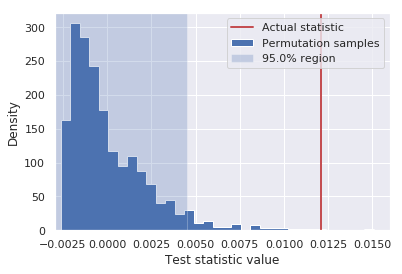

In [34]:
# SOLUTION CELL
plot_null_samples(*mmd2_permutations(K, use_biased=False))

### Alternative methods to estimate the null distribution

There are many other way to get our hands on the distribution of the MMD test statistic under the null hypothesis.

We know that asymptotically, the distribution is an infinite sum of Chi-square variables – but it's an infinite sum, and we don't even know what sum it is, so that doesn't help us too much.
Techniques to approximate it include:

* moment matching using a Gamma distribution: fast, but doesn't result in a consistent test.
* a spectral approximation: using eigenvalues of the kernel matrix, we can estimate that infinite sum. Costly (cubic!) for large sample sets.
* wild bootstrap: a technique used for correlated samples that is similar to permuting. (It's useful for e.g. testing an MCMC chain, though.)
* linear time statistics: for those, one can often show that the null distribution is Gaussian, with a variance you can estimate in closed form.

We won't cover any of these here, since they require some more details.
The permutation test, while it can potentially be slow, is easy to understand and works for most applications (if implemented well).

[This old Shogun notebook](https://nbviewer.jupyter.org/github/shogun-toolbox/shogun/blob/develop/doc/ipython-notebooks/statistical_testing/mmd_two_sample_testing.ipynb) contains many null approximation methods.

## MMD witness function in the RKHS

One nice feature of the MMD is that we can see where the density functions are different by looking at the (empirical) MMD witness function.
Remember that
\begin{align}
\MMD(\PP, \QQ)
  &= \sup_{f : \lVert f \rVert_\h \le 1} \E_{X \sim \PP} f(X) - \E_{Y \sim \QQ} f(Y)
\\&= \sup_{f : \lVert f \rVert_\h \le 1} \langle f, \E_{X \sim \PP}[\varphi(X)] - \E_{Y \sim \QQ}[\varphi(Y)] \rangle_\h
\end{align}
and so
$$
f^* \propto \E_{X \sim \PP}[\varphi(X)] - \E_{Y \sim \QQ}[\varphi(Y)]
,$$
which means (using $f^*(t) = \langle f^*, \varphi(t) \rangle_\h$)
$$
f^*(t) \propto \E_{X \sim \PP} k(X, t) - \E_{Y \sim \QQ} k(Y, t)
.$$

We can estimate $f^*$ with empirical averages.

**Thought exercises:**
- What's the proportionality constant hidden by $\propto$?
- Does the constant matter?
- Which MMD estimator, if any, does directly estimating $f^*$ correspond to?

The points where $\lvert f^*(t) \rvert$ are large are where the MMD test considers $\PP$ and $\QQ$ to be the "most different."
Let's define a grid and evaluate the witness function on it to see where that is.

**Exercise:** Finish the `mmd_witness` function to evaluate the witness function.

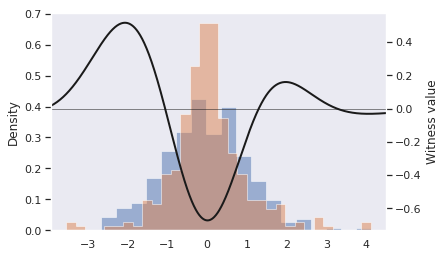

In [35]:
def mmd_witness(K, eval_pts):
    assert K.n_parts == 2
    K.append_part(eval_pts[:, None])  # now K.XZ compares X to eval_pts
    
    witness = 0
    # TODO: estimate MMD witness function on grid_pts
    witness = K.XZ.mean(0) - K.YZ.mean(0)                                    # SOLUTION
    witness = witness / np.sqrt(mmd2_biased(K))  # to normalize; maybe not necessary  # SOLUTION
    
    K.drop_last_part()
    return witness


def plot_mmd_witness_1d(K, ax=None, grid_num=1000):
    X, Y = [t.squeeze(1) for t in K.parts]
    assert len(X.shape) == 1
    
    if ax is None:
        ax = plt.gca()
    ax.hist(X.numpy(), alpha=.5, density=True, histtype='stepfilled', bins='auto')
    ax.hist(Y.numpy(), alpha=.5, density=True, histtype='stepfilled', bins='auto')
    ax.grid(False)
    ax.set_ylabel("Density")
    
    ax2 = ax.twinx()
    lo, hi = ax2.get_xlim()
    grid_pts = torch.linspace(lo, hi, grid_num)
    ax2.plot(grid_pts.numpy(), mmd_witness(K, grid_pts).numpy(), color='k', lw=2)
    ax2.set_xlim(lo, hi)
    ax2.grid(False)
    ax2.axhline(0, color='k', lw=0.5)
    ax2.set_ylabel("Witness value")
    
plot_mmd_witness_1d(ExpQuadKernel(X, Y))

As we can see, the witness function is positive where X as a higher density than Y, and negative vice versa.
It is zero where both densities match.
Intuitively, the RKHS norm of this function can only be zero if the densities match everywhere, and it grows as the densities differ on more and more points in their support.
Of course, this kind of visualization only works in low dimensions.

## Choosing a kernel

So far, we've been using `ExpQuadKernel` with its default `sigma=1`. That's a pretty arbitrary choice; what if we tried some different values?

**Thought exercise:** What do you expect the test results and witness functions to look like if we try larger or smaller sigmas (as the next block does)?

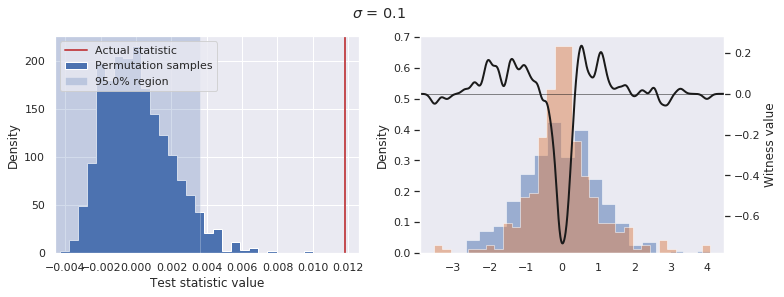

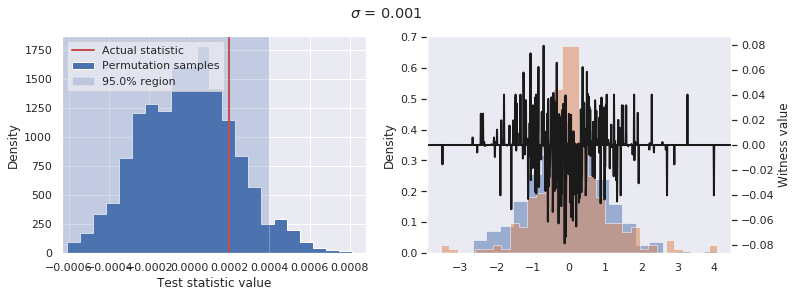

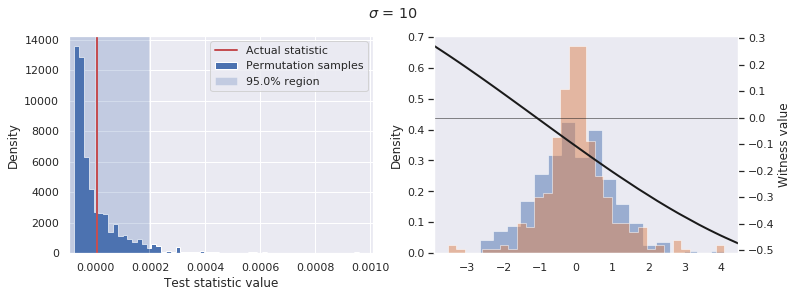

In [36]:
for sig in [.1, .001, 10]:
    K = ExpQuadKernel(X, Y, sigma=sig)
    fig, (a1, a2) = plt.subplots(ncols=2, figsize=(12, 4))
    plot_null_samples(*mmd2_permutations(K, use_biased=False), ax=a1)
    plot_mmd_witness_1d(K, ax=a2)
    fig.suptitle(f"$\sigma$ = {sig}")

Make sure you intuitively understand what happened here (especially the witness plots).

Anyway, bandwidth 1 is a totally arbitrary choice that depends on the scaling of the data. We're going to talk about how to make actual, data-informed choices in a minute. But first, it's a good idea to start with a heuristic that usually works:

[![](https://github.com/mlss-skoltech/tutorials/blob/master/kernels/dril-heuristic.png?raw=1)](https://twitter.com/dril/status/484722159462260736)

In our case, the choice we can try evbery time is the "median heuristic": set $\sigma$ to the median of the distance between data points.

**Exercise:** compute the median distance between training data points. You can either compute this yourself, or use predefined functions, whichever you'd prefer. If it's too slow to compute, you can subsample the data points.

0.8674025535583496

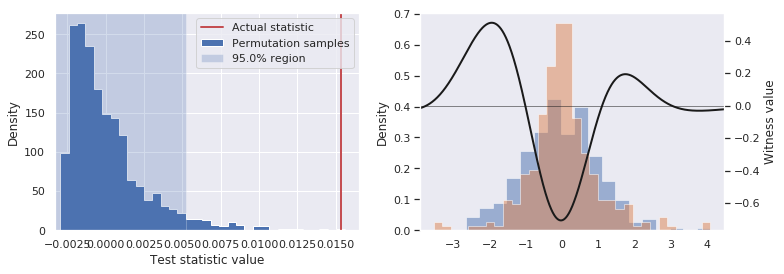

In [37]:
def median_distance(Z):
    # TODO: return the median distance among the stacked samples Z
    # If you want to be fancy, add options to optionally subset if Z is big.
    return torch.median(torch.pdist(Z))  # SOLUTION

med = median_distance(torch.cat([X, Y], 0))
K = ExpQuadKernel(X, Y, sigma=med)

fig, (a1, a2) = plt.subplots(ncols=2, figsize=(12, 4))
plot_null_samples(*mmd2_permutations(K), ax=a1, one_sided=True)
plot_mmd_witness_1d(K, ax=a2)

med.item()

So the default 1 wasn't too far off, actually. The median heuristic worked great!

But it doesn't always.

### A dataset where the median heuristic doesn't work

In [0]:
# SOLUTION CELL
from sklearn.utils import check_random_state

def sample_blobs(n=500, ratio=0.01, rows=10, cols=10, sep=10, rs=None):
    rs = check_random_state(rs)
    # ratio is eigenvalue ratio
    correlation = (ratio - 1) / (ratio + 1)

    # generate within-blob variation
    mu = np.zeros(2)
    sigma = np.eye(2)
    X = rs.multivariate_normal(mu, sigma, size=n)

    corr_sigma = np.array([[1, correlation], [correlation, 1]])
    Y = rs.multivariate_normal(mu, corr_sigma, size=n)

    # assign to blobs
    X[:, 0] += rs.randint(rows, size=n) * sep
    X[:, 1] += rs.randint(cols, size=n) * sep
    Y[:, 0] += rs.randint(rows, size=n) * sep
    Y[:, 1] += rs.randint(cols, size=n) * sep

    return X.astype(np.float32), Y.astype(np.float32)

X, Y = sample_blobs(rs=0)
np.savez(os.path.join(DATA_PATH, 'blobs.npz'), X=X, Y=Y)

X, Y = sample_blobs(rs=1)
np.savez(os.path.join(DATA_PATH, 'blobs2.npz'), X=X, Y=Y)

X, Y = sample_blobs(rs=2, rows=1, cols=1)
np.savez(os.path.join(DATA_PATH, 'blobs_single.npz'), X=X, Y=Y)

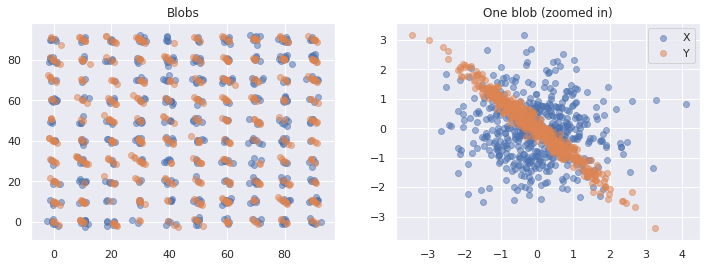

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

with np.load(os.path.join(DATA_PATH, 'blobs.npz')) as d:
    X, Y = as_tensors(d['X'], d['Y'])
ax1.scatter(*X.t(), alpha=.5, label='X')
ax1.scatter(*Y.t(), alpha=.5, label='Y')
# ax1.legend()
ax1.set_title("Blobs")

with np.load(os.path.join(DATA_PATH, 'blobs_single.npz')) as d:
    ax2.scatter(*d['X'].T, alpha=0.5, label='X')
    ax2.scatter(*d['Y'].T, alpha=0.5, label='Y')
ax2.legend()
ax2.set_title("One blob (zoomed in)");

These two distributions are clearly very different. But the scale at which they're different is much smaller than the median distance, which looks mostly at global structure.

51.60186767578125

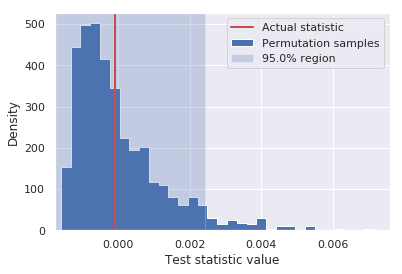

In [40]:
med = median_distance(torch.cat([X, Y], 0))
K = ExpQuadKernel(X, Y, sigma=med)

plot_null_samples(*mmd2_permutations(K))
med.item()

## Learning kernels by maximizing (a proxy for) test power

So, we want some way to find the best test, where "best" means "most powerful." That is, we want some criterion where we can get a sense of how powerful a test is – preferably without having to run the test lots of times, since that'll take lots of data and computation.

There are a few possible schemes to do this. Here we're going to consider one that depends on a little math.

We need to maximize the test power – the probability of rejecting when $\PP \ne \QQ$:

$$
     \Pr\left( m \MMDhat_U^2(X, Y) > \hat c_\alpha \right)
$$     

It turns out that under the alternative $\PP \ne \QQ$,
$\MMDhat_U^2$ is asymptotically normal,
$$
\frac{\MMDhat_U^2(X, Y) - \MMD^2(\PP, \QQ)}{\sqrt{\Var_{X' \sim \PP^m, Y' \sim \QQ^m}\left[ \MMDhat_U^2(X', Y') \right]}}
\stackrel{D}{\to}
\mathcal N(0, 1)
.$$
Call that thing in the denominator,
which is the variance of $\MMDhat_U^2$ given samples of size $m$ from $\PP$ and $\QQ$,
$V_m(\PP, \QQ)$.

Under the null hypothesis $\PP = \QQ$,
we have that $m \MMDhat_U^2(X, Y)$ converges to some gross distribution (an infinite mixture of chi-squares).
Let $c_\alpha$ be the $(1-\alpha)$th quantile of that distribution,
the rejection threshold;
we don't know that exactly,
but we can estimate it with permutation testing as $\hat c_\alpha$.
In this framework, note that $c_\alpha$ depends on $\PP$ and $\QQ$ (and the kernel in the MMD)
but it *doesn't* depend on $m$,
and in the usual setting we have
$\hat c_\alpha \to c_\alpha$.

So, for the test power we get

\begin{align}
     \Pr\left( m \MMDhat_U^2(X, Y) > \hat c_\alpha \right)
  &= \Pr\left(
       \frac{\MMDhat_U^2(X, Y) - \MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
     > \frac{\hat c_\alpha / m - \MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
   \right)
\\&\to 1 - \Phi\left(
        \frac{c_\alpha / m - \MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
    \right)
\\&= \Phi\left(
      \frac{\MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}
    - \frac{c_\alpha}{m \sqrt{V_m(\PP, \QQ)}}
    \right)
\end{align}

We can then maximize the power of the test by maximizing the thing inside the parentheses.

Now, it turns out that for a fixed kernel, $V_m$ is $\mathcal{O}(1 / m)$, and $\MMD^2$ and $c_\alpha$ are constants. So the first term is $\mathcal{O}\left(\sqrt{m}\right)$ and the second is $\mathcal{O}\left(1 / \sqrt{m}\right)$ – which means we should be able to just ignore the second term when $m$ is reasonably large.

That means we need to choose $k$ to maximize
$$t := \frac{\MMD^2(\PP, \QQ)}{\sqrt{V_m(\PP, \QQ)}}.$$
This is a function of the kernel and $\PP$ and $\QQ$, *not* our particular sample from it, but we can estimate $t$ based on samples. We know how to estimate $\MMD^2$, and it turns out you can also estimate $V_m$ in the same quadratic time: see [this note](https://arxiv.org/abs/1906.02104). Then you can just divide the estimators.
That note is 12 pages of dense equations, so...I'll be here when you're done.

(Don't actually read it.)

**Bonus points:** Find a mistake in the note. I checked it three times, but I wouldn't be at all surprised if there are still mistakes!

**Big bonus points:** Figure out a way to simplify the derivation. Seriously, huge bonus points.

Anyway, even the _expression_ for the estimator is too disgusting to write here. But I implemented it for you, in [`support.mmd2_u_stat_variance`](support/mmd.py). (*That's* what the `Matrix` subclasses are really for.)

In [0]:
from probability_testing.support import mmd2_u_stat_variance
# mmd2_u_stat_variance(K) estimates V_m based on K.XX, K.XY, K.YY

To do permutation testing with kernel selection, we have two choices:

- Do permutations of the *whole* test procedure, including picking a kernel. This is valid, but usually super computationally expensive.

- Fit the kernel on a training set, and then run the final test on a held-out test set. (If we pick the kernel on the same set we test on, then we're likely to overfit: to pick a kernel that happens to work well on this particular dataset, but not the whole distribution.)

In real life, if `X` and `Y` were all we had, we'd have to split them up (and guess at how much to split them by...) into a "training" and a "testing" set.

**Quick thought exercise:** What are the tradeoffs when picking a bigger training set versus a bigger testing set? When would one be a better choice? Can you try multiple values and see?

<p style="color: blue"><b>Answer:</b> If the kernel parameter is relatively unimportant, or easy to pick, then a bigger testing set will give you more of a chance to identify the difference in the data. But a bigger training set will give you more ability to pick the best kernel. Unfortunately, you can only try one split (unless you correct for multiple testing).</p> <!-- SOLUTION -->

Because I'm generous, I'm going to provide you with another set of samples to learn a kernel on. Enjoy!

In [0]:
with np.load(os.path.join(DATA_PATH, 'blobs2.npz')) as d:
    X_train, Y_train = as_tensors(d['X'], d['Y'])

**Exercise:** Compare a fixed set of kernels, the different bandwidths on the blobs data, using this criterion.

This is an unbiased estimator, so it might be negative, or zero! Make sure you don't divide by zero, or take the square root of a negative number.

In [0]:
def criterion_est(K, eps=1e-6):
    # TODO: return an estimate of the power criterion above
    # You can use eps to avoid dividing by zero, as you please.
    eps, = K.as_tensors(eps)
    return mmd2_u_stat(K) / torch.max(eps, mmd2_u_stat_variance(K)).sqrt()  # SOLUTION

In [44]:
# check the function runs
criterion_est(ExpQuadKernel(X_train, Y_train, sigma=1))

tensor(0.0215)

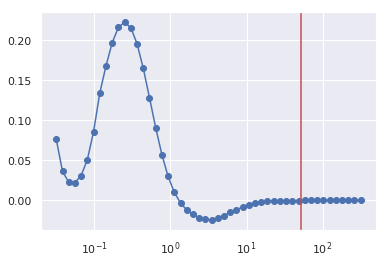

In [45]:
# evaluate criterion for a bunch of sigmas
sigmas = np.logspace(-1.5, 2.5, num=50)
t_ests = [criterion_est(ExpQuadKernel(X_train, Y_train, sigma=s)) for s in tqdm(sigmas)]

plt.plot(sigmas, t_ests, marker='o')
plt.xscale('log')
plt.axvline(med, color='r')

**Optional:** We know how to estimate $c_\alpha$ – with permutation testing – so we could optimize the more-complete criterion, too. Does that give you different answers?

([`torch.kthvalue`](https://pytorch.org/docs/stable/torch.html#torch.kthvalue) might be useful. Also, remember that $c_\alpha$ is the permutation threshold for the distribution of $m \, \MMDhat^2$, not just plain $\MMDhat^2$.)

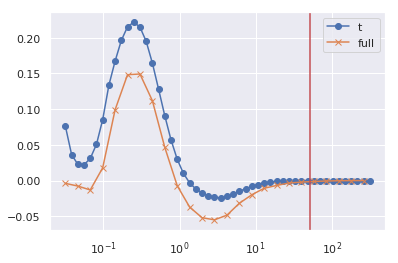

In [46]:
# SOLUTION CELL

def full_criterion_est(K, level=0.05, eps=1e-6, num_permutations=500, **kwargs):
    eps, = K.as_tensors(eps)
    mmd2, nulls = mmd2_permutations(K, use_biased=True, num_permutations=num_permutations, **kwargs)
    thresh_over_m, _ = nulls.kthvalue(int(num_permutations * (1 - level)))
    num = mmd2 - thresh_over_m
    den = torch.max(eps, mmd2_u_stat_variance(K)).sqrt()
    return num / den

sub_sigmas = sigmas[::2]  # be a little faster
full_ests = [full_criterion_est(ExpQuadKernel(X_train, Y_train, sigma=s)) for s in tqdm(sub_sigmas)]

plt.plot(sigmas, t_ests, marker='o', label='t')
plt.plot(sub_sigmas, full_ests, marker='x', label='full')
plt.axvline(med, color='r')
plt.xscale('log')
plt.legend(loc='best')

### Gradient descent to optimize the power criterion

What if we have more than one or two kernel parameters? What if we have dozens, or even (if we have really big datasets) thousands, or millions? Then trying out a grid of different combinations isn't going to work well. Instead, we can be good deep learners and do gradient descent.

(This is why we did everything in PyTorch!)

**Exercise:** Instead of doing a grid search, optimize $\sigma$ with gradient descent.

It's probably a better idea to parameterize it with $\log \sigma$ instead of $\sigma$ directly.

Does it always go to the same place, or can you get stuck in local minima?

Text(0.5, 0, 'iteration')

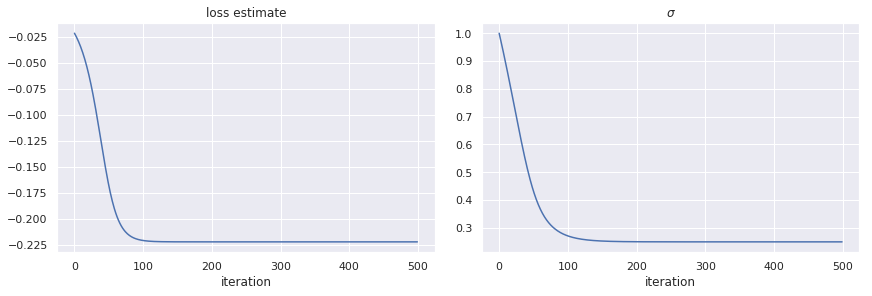

In [47]:
log_sigma = torch.tensor(np.log(1), requires_grad=True)
opt = torch.optim.SGD([log_sigma], lr=.1)  # could fiddle with optimizer if you want

trace = []
with tqdm(range(500)) as bar:  # <- feel free to increase the number of iterations
    for i in bar:
        opt.zero_grad()  # reset gradient state before computing things
        
        sigma = torch.exp(log_sigma)
        
        # TODO: compute into `loss` here, as the thing you want to *minimize*
        
        # Ideally, our kernel class would be able to cache                       # SOLUTION
        # distances between iterations here since we're only changing sigma...   # SOLUTION
        # but it can't.                                                          # SOLUTION
        K = ExpQuadKernel(X_train, Y_train, sigma=sigma)                         # SOLUTION
        t_est = criterion_est(K)                                                 # SOLUTION
        loss = -t_est  # could add regularization here, etc                      # SOLUTION
        
        loss.backward()  # compute the gradients
        opt.step()       # update log_sigma along its gradient
        
        sig_val = sigma.cpu().item()
        loss_val = loss.cpu().item()
        
        trace.append((i, sig_val, loss_val))
        bar.set_postfix(sigma=f"{sig_val:.4}", loss=f"{loss_val:.4}")

fig, (a1, a2) = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)
inds, sigs, losses = np.asarray(trace).T

a1.plot(inds, losses)
a1.set_title("loss estimate")
a1.set_xlabel("iteration")

a2.plot(inds, sigs)
a2.set_title(r"$\sigma$")
a2.set_xlabel("iteration")

Let's check how our test works now

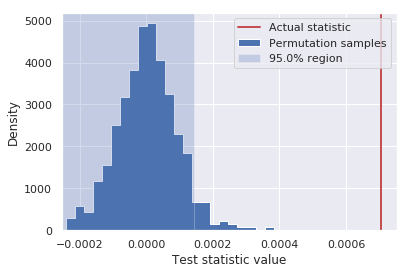

In [48]:
K = ExpQuadKernel(X, Y, sigma=sigma.detach())

plot_null_samples(*mmd2_permutations(K, num_permutations=500))

# Independence testing

So far, we've been asking whether $\PP = \QQ$ for two different distributions. Sometimes we'd rather do a related problem, *independence testing*. That is, we have paired data $\{ (X_i, Y_i) \}_{i=1}^n \sim \PP_{XY}^n$, and we want to know whether $X$ and $Y$ are independent or not.

By definition, this is the same thing as asking whether $\PP_{XY} = \PP_X \times \PP_Y$, the product of the marginal distributions. But we know how to do that: if we use a characteristic kernel on the joint space, they're independent if and only if $\MMD(\PP_{XY}, \PP_{X} \times \PP_Y) = 0$.
The quantity $\MMD(\PP_{XY}, \PP_{X} \times \PP_Y)^2$  is also called the HSIC ("Hilbert-Schmidt Independence Criterion"). 

Usually we choose a kernel $k$ for $X$ and a kernel $\ell$ for $Y$, and use the _product kernel_ on the joint space:
$$
  (k \times \ell)( (x, y), (x', y') )
  = k(x, x') \ell(y, y')
.$$
It turns out you can estimate it like this:
$$
\frac{1}{n^2} \Tr\left( H K H L \right)
,$$
where $K$ is the kernel matrix on the $X$ samples,
$L$ is the kernel matrix on the $L$ samples,
and $H = I - \frac1n \mathbf{1} \mathbf{1}^T$ is the _centering matrix_.
(Here $I$ is the identity matrix, and $\mathbf 1$ is a vector of all $1$s.)

**Exercise:** Implement the HSIC estimator. You can do it literally as written here, with an H matrix and taking matrix products and so on. Or, if you want a more efficient implementation – $\mathcal{O}(n^2)$ instead of $\mathcal{O}(n^3)$ – you can notice a few things:

- If you expand out what $H K H$ does, it can be done in quadratic time without actually constructing $H$.
- $\Tr(A B) = \sum_i ( A B )_{ii} = \sum_i \sum_j A_{ij} B_{ji}$, which you can easily implement in quadratic time.

In [0]:
def _as_kernel_matrices(K, L):
    if isinstance(K, LazyKernel):
        K = K.XX
    if isinstance(L, LazyKernel):
        L = L.XX
    K, L = as_tensors(K, L)
    assert len(K.shape) == len(L.shape) == 2
    assert K.shape[0] == K.shape[1] == L.shape[0] == L.shape[1]
    return K, L

In [0]:
def hsic_est(K, L):
    K, L = _as_kernel_matrices(K, L)
    
    # TODO: implement the HSIC estimator
    
    if False:  # the slower way:                          # SOLUTION
        n = K.shape[0]                                    # SOLUTION
        H = torch.eye(n, dtype=K.dtype, device=K.device)  # SOLUTION
        hsic = (H @ K @ H @ L).trace() / (n * n)          # SOLUTION
    else:                                                 # SOLUTION
        # (I - 1/n 1 1^T) K (I - 1/n 1 1^T)               # SOLUTION
        #   = K - 1/n 1 (1^T K) - 1/n (K 1) 1^T           # SOLUTION
        #       + 1/n^2 1 (1^T K 1) 1^T                   # SOLUTION
        row_means = K.mean(0, keepdim=True)               # SOLUTION
        col_means = row_means.t()  # K is symmetric       # SOLUTION
        grand_mean = row_means.mean(1, keepdim=True)      # SOLUTION
        K_cent = K - row_means - col_means + grand_mean   # SOLUTION
        L_transp = L  # L is symmetric too                # SOLUTION
        hsic = (K_cent * L_transp).mean()                 # SOLUTION
    return hsic

To run a test, we'll also need to do permutations. Note that permutations are slightly different from before: we'll need to permute $K$ and $L$ *separately*, so that $\{(x_i, y_i)\}$ becomes $\{(x_i, y_j)\}$, and any possible dependence between them is broken.

Here's some framework for computing permuations for the HSIC estimator. If you want to do it a faster way, go ahead.

In [0]:
def hsic_permutations(K, L, num_permutations=1000, progress=True):
    K, L = _as_kernel_matrices(K, L)

    est = hsic_est(K, L)

    range_ = range(num_permutations)
    if progress:
        range_ = tqdm(range_)
    
    n = K.shape[0]       # SOLUTION
    stats = []
    for i in range_:
        pass # TODO: permute the entries of K and L and call hsic_est
        oK = torch.randperm(n)            # SOLUTION
        Kp = K[oK[:, None], oK[None, :]]  # SOLUTION
        oL = torch.randperm(n)            # SOLUTION
        Lp = L[oL[:, None], oL[None, :]]  # SOLUTION
        stats.append(hsic_est(Kp, Lp))    # SOLUTION
        # Note: we really only need to shufle one of them.              # SOLUTION
        # And centering isn't affected by the order,                    # SOLUTION
        # so it'd be a little faster to center beforehand and keep it.  # SOLUTION
        
    return est, torch.stack(stats)

Let's try it on some simple data.

In [0]:
# SOLUTION CELL
def sample_hsic(n, angle, sigma=0.2, offset=1):
    n4 = n // 4
    N = np.random.randn(n4, 2) * sigma
    S = np.random.randn(n4, 2) * sigma
    E = np.random.randn(n4, 2) * sigma
    W = np.random.randn(n4, 2) * sigma
    
    N[:,1] += offset
    S[:,1] -= offset
    W[:,0] -= offset
    E[:,0] += offset
    
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    A = R.dot(np.vstack((N, S, W, E)).T).T
    
    A = A.astype(np.float32)
    np.random.shuffle(A)
    return A[:, 0], A[:, 1]

N = 200
np.random.seed(0)
X, Y = sample_hsic(n=N, angle=np.pi / 12)
np.savez(os.path.join(DATA_PATH, "hsic.npz"), X=X[:, None], Y=Y[:, None])

In [0]:
with np.load(os.path.join(DATA_PATH, 'hsic.npz')) as d:
    X, Y = as_tensors(d['X'], d['Y'])

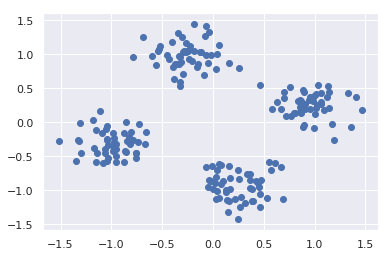

In [54]:
fig, ax = plt.subplots()
ax.scatter(X, Y)

Clearly, there is some very simple dependence going on.
The first thing a statistician would do is of course to check for correlation.

In [55]:
print("Correlation between X and Y:", np.corrcoef(X.squeeze(), Y.squeeze())[0, 1])

Correlation between X and Y: 0.023122960723689173


The correlation is very low.
A kernel test for independence is more powerful, even with a bandwidth parameter chosen by the median heuristic.

**Exercise:** Implement and visualize this test.

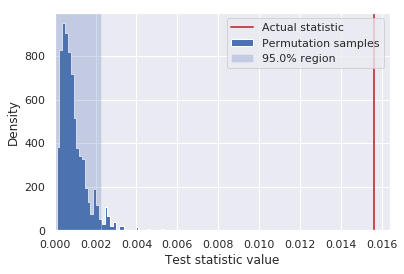

In [56]:
# SOLUTION CELL

K = ExpQuadKernel(X, sigma=median_distance(X))
L = ExpQuadKernel(Y, sigma=median_distance(Y))
plot_null_samples(*hsic_permutations(K, L), from_zero=True)

Pretty resounding rejection of the null hypothesis.

**Optional**: Do we already have the code for doing an actual hypothesis test based on the correlation coefficient? Implement it and run the test to verify that it is not very powerful here. 

<!-- SOLUTION CELL -->
<p style="color: blue">
The feature embedding function $\varphi(x)$ for a linear kernel is just $\varphi(x) = x$.
When we take the product kernel of two of these,
we get the outer product,
$\varphi((x, y)) = x y^T$.
The HSIC is then
$$
     \MMD(\PP_{XY}, \PP_X \times \PP_Y)^2
   = \left\lVert \E [X Y^T] - [\E X] [\E Y]^T \right\rVert^2 
,$$
exactly the squared covariance.
</p>

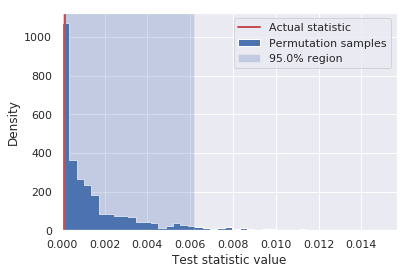

In [57]:
# SOLUTION CELL
plot_null_samples(*hsic_permutations(LinearKernel(X), LinearKernel(Y)), from_zero=True)

## European parliament documents translations and string kernels

We will now do a slightly more elaborate test, that involves some very mild NLP:
we'll analyze dependence between documents.
We will use transcripts of the Canadian parliament's house debates, downloaded from [here](https://www.isi.edu/natural-language/download/hansard/).
Those consist of pairs of French and English transcripts. Here's the end of two corresponding documents:

> d until tomorrow at 2 p.m., pursuant to Standing Order 24(1).  
> (The House adjourned at 6.41 p.m.) 

> main, à 10 heures, conformément à l'article 24(1) du Règlement.  
> (La séance est levée à 18 h 20.) 

Our question here is whether we can detect this supposedly strong dependence structure using the kernel HSIC.
Note that this approach does not rely on attempting to translate the documents, but rather on comparing within-document structure. 
HSIC compares the self-similarity within the English documents with self-similarity of the French ones.

We're going to construct a string kernel, a  "bag of words" kernel between documents $s$ and $t$,
$$
k(s,t) = \phi(s)^\top \phi(t)
$$
where $\mathcal W$ is the set of all words that we consider,
and each element of $\phi(x)\in\mathbb{N}^{|\mathcal{W}|}$ contains the number of times that a particular word $w\in\mathcal{W}$ appears in $x$.
The kernel value will be larger if a word appears in both documents many times.
We're going to keep things simple and actually construct the representation $\phi$ for each document.

There are also better choices for string kernels, that actually take into account the structure of a word.
(Shogun has efficient implementations of many classical ones, usually based on low-level dynamic programming concepts;
you can also define them based on modern word embeddings.)
But simple word counts will be enough for us here.

In [0]:
# stopwords, from nltk.corpus.stopwords:
# words like "the", "our" (in English) or "le", "avec" (in French)
# that we don't want overwhelming the meaningful words, so we just skip
with open(os.path.join(DATA_PATH, 'stopwords-english.txt')) as f:
    en_stop = {x.strip() for x in f}
with open(os.path.join(DATA_PATH, 'stopwords-french.txt')) as f:
    fr_stop = {x.strip() for x in f}

To compute $\phi$, we would normally need to do a first pass to explicitly keep track of all the words $\mathcal W$. This can be kind of slow, though, so instead we're going to use the "hashing trick." Rather than keeping track of a vocabulary, we use a hash function ([MurmurHash](https://en.wikipedia.org/wiki/MurmurHash)) to map each word to a (probably) unique index. To avoid hash collisions, we make $\phi$ very high-dimensional ($2^{20} \approx 1,000,000$), but use a sparse representation so that doesn't take much memory.

In [0]:
import re
import tarfile
from scipy import sparse

en_feats = {}
fr_feats = {}

from sklearn.feature_extraction.text import HashingVectorizer
en_vec = HashingVectorizer(
    analyzer="word", decode_error='replace', stop_words=en_stop,
)
fr_vec = HashingVectorizer(
    analyzer="word", decode_error='replace', stop_words=fr_stop,
)

with tarfile.open(os.path.join(DATA_PATH, 'transcripts.tar.bz2')) as tar:
    for info in tqdm(tar, total=627):
        fname = info.name
        is_french = fname.endswith("f")
        is_english = fname.endswith("e")
        if not (is_english or is_french):
            continue
        
        with tar.extractfile(info) as f:
            if is_english:
                en_feats[fname] = en_vec.transform([f.read()])
            else:
                fr_feats[fname] = fr_vec.transform([f.read()])

assert len(en_feats) == len(fr_feats)
names = {k[:-1] for k in en_feats}
X = sparse.vstack([en_feats[k + 'e'] for k in names])
Y = sparse.vstack([fr_feats[k + 'f'] for k in names])

Our features are enormous (and enormously sparse) matrices.

In [0]:
X

**Exercise:** Construct linear kernel matrices for the French and English data.

Now, our PyTorch kernel infrastructure isn't going to love trying to construct a matrix with a million columns. We're only going to use a linear kernel, though, so we can just compute the kernel ourselves. (You can convert from these sparse matrix classes to numpy arrays with `toarray()`, but do it *after* computing the kernel matrix to avoid trying to allocate an enormous dense array:

In [0]:
# TODO: compute kernels
K_XX = (
    # ...
    X @ X.T   # SOLUTION
).toarray().astype(np.float32)
K_YY = (
    # ...
    Y @ Y.T   # SOLUTION
).toarray().astype(np.float32)

**Exercise:** Run the HSIC test.

In [0]:
# SOLUTION CELL
plot_null_samples(*hsic_permutations(K_XX, K_YY), from_zero=True)

We can clearly see that the English and French documents are not independent.

<br>
<br>